# MNIST with `ipcmagic` and TensorFlow-2.2

 * The two nodes have different names
 * Both nodes are using the GPU
 * After running `ipcluster stop` the GPU memory ussage goes to zero.
 
 > To run this notebook it's necessary to have ipcmagic and TF2.2 modules loaded. Please use the kernel miniconda-ss2020:

```bash
. /apps/daint/UES/6.0.UP04/sandboxes/sarafael/miniconda-ss2020/bin/activate
module load daint-gpu                             
module load jupyter-utils
kernel-create -n miniconda-ss2020
```
 
Please, make sure that it doesn't conflict with any other line that you might have on your `$HOME/.jupyterhub.env` file.

In [1]:
import ipcmagic
import ipyparallel as ipp

%ipcluster start -n 2 --mpi

rc = ipp.Client()
rc.ids

IPCluster is ready! (6 seconds)


[0, 1]

In [2]:
%%px
import os
import math
import json
import numpy as np

import tensorflow as tf
tf.__version__

Out[0:1]: '2.2.0'

Out[1:1]: '2.2.0'

In [3]:
%%px
import socket
socket.gethostname(), tf.config.list_physical_devices('GPU')

Out[0:2]: 
('nid03902',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

Out[1:2]: 
('nid03903',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
%%px
# generally MultiWorkerMirroredStrategy requires 'TF_CONFIG' to be set, but in our case
# SlurmClusterResolver takes care of all the configuration
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
    cluster_resolver=tf.distribute.cluster_resolver.SlurmClusterResolver(),
    communication=tf.distribute.experimental.CollectiveCommunication.NCCL,
)

# os.environ['TF_CONFIG'] = json.dumps({
#     'cluster': {
#         'worker': [f"{os.environ['SLURM_JOB_NODELIST'][:4]}{node}:8888"
#                    for node in os.environ['SLURM_JOB_NODELIST'][5:-1].split('-')]
#     },
#     'task': {'type': 'worker', 'index': os.environ['SLURM_NODEID']}
# })
# os.environ['TF_CONFIG']

In [6]:
%%px
num_workers = int(os.environ['SLURM_NNODES'])
node_id = int(os.environ['SLURM_NODEID'])

per_worker_batch_size = 300
# Here the batch size scales up by number of workers since 
# `tf.data.Dataset.batch` expects the global batch size.
batch_size = per_worker_batch_size * num_workers

learning_rate = 5e-4 * batch_size

node_id, per_worker_batch_size, learning_rate

Out[0:5]: (0, 300, 0.3)

Out[1:5]: (1, 300, 0.3)

In [15]:
%%px
def build_and_compile_cnn_model(learning_rate=learning_rate):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.experimental.SyncBatchNormalization(name='bn0'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.experimental.SyncBatchNormalization(name='bn1'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.experimental.SyncBatchNormalization(name='bn2'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        metrics=['accuracy'])
    model.summary()
    return model


with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
    multi_worker_model = build_and_compile_cnn_model()

[stdout:0] 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
bn0 (SyncBatchNormalization) (None, 26, 26, 32)        128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
bn1 (SyncBatchNormalization) (None, 21632)             86528     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
bn2 (SyncBatchNormalization) (None, 128)  

In [16]:
%%px
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_size = len(y_train)
valid_size = len(y_test)

# The `x` arrays are in uint8 and have values in the range [0, 255].
# We need to convert them to float32 with values in the range [0, 1]
train_dataset = (tf.data.Dataset
                        .from_tensor_slices((x_train / np.float32(255), y_train.astype(np.int64)))
                        .shuffle(train_size)
                        .repeat()
                        .batch(batch_size, drop_remainder=True))

valid_dataset = (tf.data.Dataset
                        .from_tensor_slices((x_test / np.float32(255), y_test.astype(np.int64)))
                        .batch(batch_size, drop_remainder=False))

# In multi-worker training with MultiWorkerMirroredStrategy, sharding the dataset
# is needed to ensure convergence and performance. However, note that in code here,
# the datasets are directly passed to model.fit() without needing to shard; this is
# because tf.distribute.Strategy API takes care of the dataset sharding automatically.

train_size, valid_size

Out[0:14]: (60000, 10000)

Out[1:14]: (60000, 10000)

[output:0]

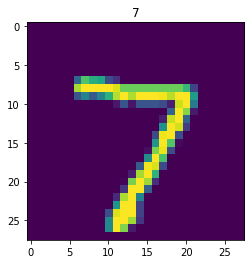

[output:1]

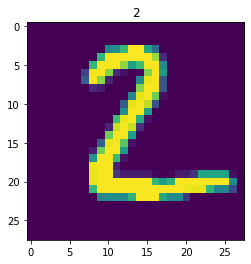

Out[0:15]: Text(0.5, 1.0, '7')

Out[1:15]: Text(0.5, 1.0, '2')

In [17]:
%%px
from matplotlib import pyplot as plt
plt.imshow(x_test[node_id])
plt.title(str(y_test[node_id]))

In [18]:
%%px
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
output_path = os.environ['SCRATCH'] + "/summer_school/keras-mnist"
tb_logdir = f'{output_path}/logs/{timestr}'

tb_logdir

Out[0:16]: '/scratch/snx3000/class104/summer_school/keras-mnist/logs/20200724-110804'

Out[1:16]: '/scratch/snx3000/class104/summer_school/keras-mnist/logs/20200724-110804'

In [19]:
import os, shutil
from tb_cscs import tensorboard

tb_logdir = os.environ['SCRATCH'] + "/summer_school/keras-mnist/logs"
shutil.rmtree(tb_logdir, ignore_errors=True)

%tensorboard  --logdir={tb_logdir}  --host localhost

Reusing TensorBoard on port 6006 (pid 31352), started 0:07:52 ago. (Use '!kill 31352' to kill it.)

In [23]:
%%px
# Keras' `model.fit()` trains the model with specified number of steps and epochs across all nodes
steps_per_epoch = train_size // batch_size
validation_steps = math.ceil(valid_size / batch_size)
print(f'Training for {steps_per_epoch} steps per epoch across {num_workers} nodes')

[stdout:0] Training for 100 steps per epoch across 2 nodes
[stdout:1] Training for 100 steps per epoch across 2 nodes


In [24]:
%%px

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir,
                                                update_freq=steps_per_epoch//10, # 10x/epoch
                                                histogram_freq=0,
                                                profile_batch=0)

multi_worker_model.fit(train_dataset,
                       epochs=7,
                       steps_per_epoch=steps_per_epoch,
                       validation_data=valid_dataset,
                       validation_steps=validation_steps,
                       callbacks=[tensorboard_cb],
                      )

[stdout:0] 
Epoch 1/7
100/100 [==============================] - 1s 14ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9818 - val_loss: 0.0718
Epoch 2/7
100/100 [==============================] - 1s 15ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9832 - val_loss: 0.0655
Epoch 3/7
100/100 [==============================] - 1s 14ms/step - accuracy: 1.0000 - loss: 9.4949e-04 - val_accuracy: 0.9835 - val_loss: 0.0644
Epoch 4/7
100/100 [==============================] - 1s 14ms/step - accuracy: 1.0000 - loss: 7.5268e-04 - val_accuracy: 0.9842 - val_loss: 0.0633
Epoch 5/7
100/100 [==============================] - 1s 15ms/step - accuracy: 1.0000 - loss: 5.4879e-04 - val_accuracy: 0.9839 - val_loss: 0.0700
Epoch 6/7
100/100 [==============================] - 1s 15ms/step - accuracy: 1.0000 - loss: 4.7498e-04 - val_accuracy: 0.9850 - val_loss: 0.0666
Epoch 7/7
100/100 [==============================] - 1s 14ms/step - accuracy: 1.0000 - loss: 4.1444e-04 - val_accuracy: 

In [25]:
%%px
multi_worker_model.evaluate(valid_dataset, batch_size=batch_size, steps=validation_steps)

17/17 [==============================] - 0s 3ms/step - accuracy: 0.9852 - loss: 0.0675


%ipcluster stop

#### 